analytic vt = 0.0002236067865696399 factor vcirc = 0.0004472135731392798
min r (numerical) = 9.999996617384981e-08 at t = 55.544320211347596
target rp = 1e-07
E0 -2.500e-01  Emin -2.500e-01  Emax -2.499e-01  dE/E0 4.689e-04
L0 2.236e-04  Lmin 2.236e-04  Lmax 2.236e-04  dL/L0 2.684e-07
first few min r values around minima:
27190 55.54432021134615 1.0002767348916443e-07
27191 55.54432021134663 1.0001257212053409e-07
27192 55.54432021134711 1.0000333779915887e-07
27193 55.544320211347596 9.999996617384981e-08
27194 55.54432021134808 1.0000245527851267e-07
27195 55.54432021134856 1.0001080425288796e-07
27196 55.544320211349046 1.0002501314958642e-07


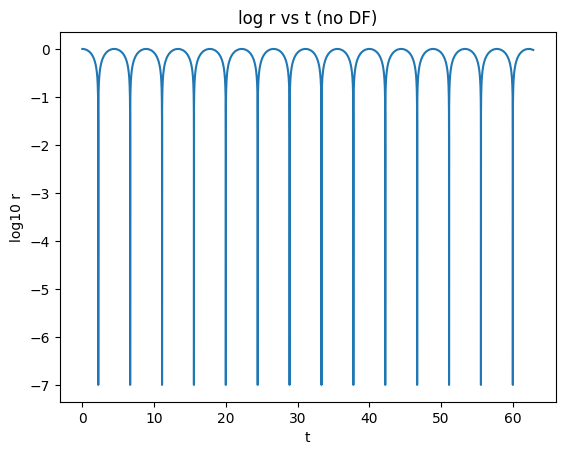

In [11]:
import numpy as np
import matplotlib.pyplot as plt

r0 = 1.0
rp_target = 1e-7
x0, y0 = r0, 0.0

def circular_speed(r):
    return np.sqrt(1.0 / (4.0 * r))

def vt_from_rp(r0, rp):
    # vt^2 = (0.5*(1/r0 - 1/rp)) / (1 - r0^2 / rp^2)
    rp2 = rp * rp
    r02 = r0 * r0
    num = 0.5 * (1.0 / r0 - 1.0 / rp)
    denom = 1.0 - r02 / rp2
    vt2 = num / denom
    if vt2 <= 0.0:
        raise ValueError("vt^2 <= 0: check rp/r0. computed vt2 = {}".format(vt2))
    return np.sqrt(vt2)

vt = vt_from_rp(r0, rp_target)
vc = circular_speed(r0)
print("analytic vt =", vt, "factor vcirc =", vt / vc)


def rhs(s):
    x = float(s[0]); y = float(s[1]); vx = float(s[2]); vy = float(s[3])
    r2 = x*x + y*y
    r = np.sqrt(r2) if r2 > 0.0 else 0.0
    if r > 0.0:
        pref = -1.0 / (4.0 * r2 * r)
        ax = pref * x
        ay = pref * y
    else:
        ax = ay = 0.0
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_increment(f, s, t, h):
    k1 = h * f(s)
    k2 = h * f(s + 0.5 * k1)
    k3 = h * f(s + 0.5 * k2)
    k4 = h * f(s + k3)
    return (k1 + 2*k2 + 2*k3 + k4) / 6.0

def adaptive_rk4_step_iter(f, s, t, h, delta_local, h_min=1e-16, h_max=1.0, max_retries=60):
    retries = 0
    while retries < max_retries:
        # clamp h
        if h < h_min:
            h = h_min
        if h > h_max:
            h = h_max

        # two half steps
        d1 = rk4_increment(f, s, t, h)
        s1 = s + d1
        d2 = rk4_increment(f, s1, t + h, h)
        delta_r1 = d1 + d2

        # one double step
        delta_r2 = rk4_increment(f, s, t, 2.0 * h)

        # position error (indices 0,1)
        dx1 = delta_r1[0]; dx2 = delta_r2[0]
        dy1 = delta_r1[1]; dy2 = delta_r2[1]
        diffx = dx1 - dx2
        diffy = dy1 - dy2
        error = np.sqrt(diffx*diffx + diffy*diffy) / 30.0

        if not np.isfinite(error) or error <= 0.0:
            if error == 0.0:
                rho = 1e12
            else:
                rho = 0.0
        else:
            rho = h * delta_local / error

        factor = rho**0.25 if rho > 0.0 else 0.5

        if rho >= 1.0:
            delta_r1 = delta_r1.copy()
            delta_r1[0] += diffx / 15.0
            delta_r1[1] += diffy / 15.0
            s_new = s + delta_r1
            t_new = t + 2.0 * h
            h_new = 2.0*h if factor > 2.0 else factor*h
            h_new = min(max(h_new, h_min), h_max)
            return s_new, t_new, h_new, True

        # reject: shrink and retry
        h_new = factor * h
        if h_new >= h:
            h_new = 0.5 * h
        if h_new < h_min:
            return None, None, h_min, False
        h = h_new
        retries += 1

    return None, None, h_min, False

def integrate_adaptive_iter(f, s0, T, h_init, delta_local, h_min=1e-12, h_max=1.0, stop_at_T=True):
    t = 0.0
    s = s0.copy()
    h = h_init
    times = [t]; states = [s.copy()]
    while t < T - 1e-14:
        if t + 2.0*h > T:
            h_final = T - t
            if h_final <= 0:
                break
            # one RK4 step of size h_final
            s = s + rk4_increment(f, s, t, h_final)
            t = T
            times.append(t); states.append(s.copy())
            break

        s_new, t_new, h_new, accepted = adaptive_rk4_step_iter(f, s, t, h, delta_local, h_min=h_min, h_max=h_max)
        if not accepted:
            raise RuntimeError(f"Adaptive step failed at t={t}, h_min reached. Try larger delta or larger h_min.")
        s = s_new; t = t_new; h = h_new
        times.append(t); states.append(s.copy())

    return np.array(times), np.vstack(states)


def energy(s):
    x,y,vx,vy = s
    r = np.hypot(x,y)
    kinetic = 0.5*(vx*vx + vy*vy)
    potential = -1.0/(4.0 * r) if r>0 else -np.inf
    return kinetic + potential

def angmom(s):
    x,y,vx,vy = s
    return x*vy - y*vx

# ---------- run with analytic vt ----------
s0 = np.array([x0, y0, 0.0, vt], dtype=float)
T_orbit = 2.0 * np.pi * np.sqrt(r0**3)
T = 10.0 * T_orbit

delta_local = 1e-8
times, states = integrate_adaptive_iter(rhs, s0, T, h_init=0.01, delta_local=delta_local, h_min=1e-14, h_max=1.0)

rs = np.hypot(states[:,0], states[:,1])
imin = np.argmin(rs)
print("min r (numerical) =", rs[imin], "at t =", times[imin])
print("target rp =", rp_target)


E0 = energy(s0); L0 = angmom(s0)
E_vals = np.array([energy(s) for s in states])
L_vals = np.array([angmom(s) for s in states])
print("E0 {:.3e}  Emin {:.3e}  Emax {:.3e}  dE/E0 {:.3e}".format(E0, E_vals.min(), E_vals.max(), (E_vals.max()-E_vals.min())/abs(E0)))
print("L0 {:.3e}  Lmin {:.3e}  Lmax {:.3e}  dL/L0 {:.3e}".format(L0, L_vals.min(), L_vals.max(), (L_vals.max()-L_vals.min())/abs(L0)))


print("first few min r values around minima:")
for idx in range(max(0, imin-3), min(len(rs), imin+4)):
    print(idx, times[idx], rs[idx])

plt.figure(); plt.plot(times, np.log10(rs)); plt.xlabel('t'); plt.ylabel('log10 r'); plt.title('log r vs t (no DF)')
plt.show()


Integration done: steps = 43380 t_final = 10.755685206075666
Reached r (last) = 9.987483231512835e-08


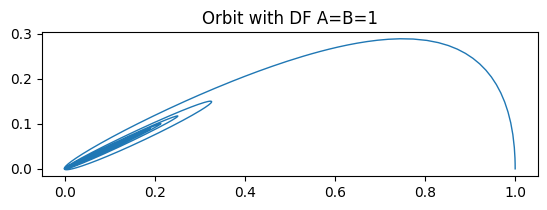

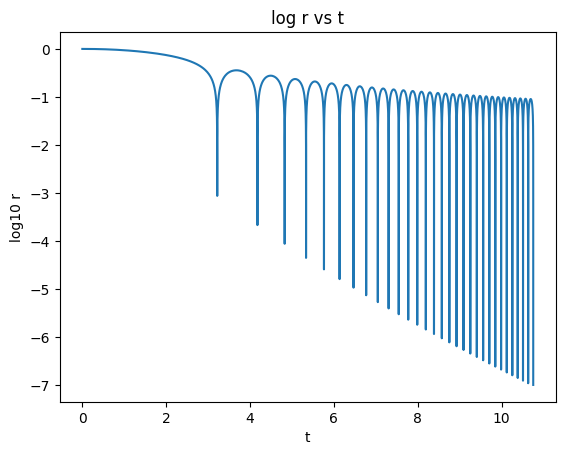

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def rk4_increment(f, s, t, h):
    k1 = h * f(s)
    k2 = h * f(s + 0.5 * k1)
    k3 = h * f(s + 0.5 * k2)
    k4 = h * f(s + k3)
    return (k1 + 2*k2 + 2*k3 + k4) / 6.0

def adaptive_rk4_step(f, s, t, h, delta_local, h_min=1e-16, h_max=1.0, max_retries=60):
    """
    Iterative step-doubling adaptive RK4.
    State layout assumed: [x, y, vx, vy]
    Returns (s_new, t_new, h_new, accepted_flag).
    If cannot meet tolerance after shrinking, returns (None, None, h_min, False).
    """
    retries = 0
    while retries < max_retries:
        if h < h_min:
            h = h_min
        if h > h_max:
            h = h_max

        d1 = rk4_increment(f, s, t, h)
        s1 = s + d1
        d2 = rk4_increment(f, s1, t + h, h)
        delta_r1 = d1 + d2

        delta_r2 = rk4_increment(f, s, t, 2.0 * h)

        dx1 = delta_r1[0]; dx2 = delta_r2[0]
        dy1 = delta_r1[1]; dy2 = delta_r2[1]

        diffx = dx1 - dx2
        diffy = dy1 - dy2
        error = np.sqrt(diffx*diffx + diffy*diffy) / 30.0

        if not np.isfinite(error) or error <= 0.0:
            if error == 0.0:
                rho = 1e12 
            else:
                rho = 0.0 
        else:
            rho = h * delta_local / error

        factor = rho**0.25 if rho > 0.0 else 0.5

        if rho >= 1.0:

            delta_r1 = delta_r1.copy()
            delta_r1[0] += diffx / 15.0
            delta_r1[1] += diffy / 15.0
            s_new = s + delta_r1
            t_new = t + 2.0 * h
            h_new = 2.0*h if factor > 2.0 else factor * h
            h_new = min(max(h_new, h_min), h_max)
            return s_new, t_new, h_new, True

        h_new = factor * h
        if h_new >= h:
            h_new = h * 0.5
        if h_new < h_min:
            return None, None, h_min, False
        h = h_new
        retries += 1

    return None, None, h_min, False

def integrate_adaptive(f, s0, Tmax, h_init, delta_local, h_min=1e-16, h_max=1.0, stop_r=1e-7):
    t = 0.0
    s = s0.copy()
    h = h_init
    times = [t]
    states = [s.copy()]

    while t < Tmax:
        if t + 2.0*h > Tmax:
            h = max(h_min, (Tmax - t) / 2.0)
            if h <= 0.0:
                break

        s_new, t_new, h_new, accepted = adaptive_rk4_step(f, s, t, h, delta_local, h_min=h_min, h_max=h_max)
        if not accepted:
            print("Warning: adaptive step failed to meet tolerance at t =", t, "; stopping integration.")
            break

        s = s_new
        t = t_new
        h = h_new

        times.append(t)
        states.append(s.copy())

        # stopping condition
        rnow = np.hypot(s[0], s[1])
        if rnow <= stop_r:
            break

    return np.array(times), np.vstack(states)

def rhs_with_df_factory(A, B):
    def rhs_with_df(s):
        x = float(s[0]); y = float(s[1]); vx = float(s[2]); vy = float(s[3])
        r2 = x*x + y*y
        r = np.sqrt(r2) if r2 > 0.0 else 0.0
        if r > 0.0:
            pref = -1.0 / (4.0 * r2 * r)
            ax = pref * x
            ay = pref * y
        else:
            ax = 0.0; ay = 0.0
        v2 = vx*vx + vy*vy
        v = np.sqrt(v2) if v2 > 0.0 else 0.0
        if v > 0.0:
            dfpref = -A / (v**3 + B)
            dfx = dfpref * vx
            dfy = dfpref * vy
        else:
            dfx = 0.0; dfy = 0.0
        return np.array([vx, vy, ax + dfx, ay + dfy], dtype=float)
    return rhs_with_df

def circular_speed(r):
    return np.sqrt(1.0/(4.0*r))

r0 = 1.0
vcirc = circular_speed(r0)
v0 = 0.8 * vcirc
s0 = np.array([r0, 0.0, 0.0, v0], dtype=float)

A = 1.0; B = 1.0
f = rhs_with_df_factory(A, B)
Tmax = 20.0  
times, states = integrate_adaptive(f, s0, Tmax, h_init=0.001, delta_local=1e-8, h_min=1e-14, h_max=1.0)

print("Integration done: steps =", len(times), "t_final =", times[-1])


rs = np.hypot(states[:,0], states[:,1])
print("Reached r (last) =", rs[-1])


mask = np.isfinite(rs) & (rs > 0)
if not np.any(mask):
    raise RuntimeError("No finite positive radii to plot.")

plt.figure()
plt.plot(states[:,0], states[:,1], '-', lw=1)
plt.gca().set_aspect('equal')
plt.title('Orbit with DF A=B=1')

plt.figure()
plt.plot(times[mask], np.log10(rs[mask]))
plt.xlabel('t')
plt.ylabel('log10 r')
plt.title('log r vs t')
plt.show()


In [9]:
import numpy as np
import math
from numba import njit, prange


r0 = 1.0
rp_target = 1e-7
x0, y0 = r0, 0.0
def circular_speed(r): return math.sqrt(1.0/(4.0*r))
vc0 = circular_speed(r0)
v_init_factor = 0.8


@njit(inline='always')
def rhs_into_numba(s, A, B, out):
    x = s[0]; y = s[1]; vx = s[2]; vy = s[3]
    r2 = x*x + y*y
    if r2 > 0.0:
        r = math.sqrt(r2)
        pref = -1.0 / (4.0 * r2 * r)
        ax = pref * x
        ay = pref * y
    else:
        ax = 0.0; ay = 0.0
    v2 = vx*vx + vy*vy
    if v2 > 0.0:
        v = math.sqrt(v2)
        dfpref = -A / (v*v*v + B)
        dfx = dfpref * vx
        dfy = dfpref * vy
    else:
        dfx = 0.0; dfy = 0.0
    out[0] = vx
    out[1] = vy
    out[2] = ax + dfx
    out[3] = ay + dfy


@njit(inline='always')
def rk4_increment_into(s, h, A, B, dst, tmp1, tmp2, tmp3, k1, k2, k3, k4):
    # k arrays and tmp arrays are preallocated float64[4]
    rhs_into_numba(s, A, B, k1); 
    for i in range(4): k1[i] *= h
    for i in range(4): tmp1[i] = s[i] + 0.5 * k1[i]

    rhs_into_numba(tmp1, A, B, k2)
    for i in range(4): k2[i] *= h
    for i in range(4): tmp2[i] = s[i] + 0.5 * k2[i]

    rhs_into_numba(tmp2, A, B, k3)
    for i in range(4): k3[i] *= h
    for i in range(4): tmp3[i] = s[i] + k3[i]

    rhs_into_numba(tmp3, A, B, k4)
    for i in range(4): k4[i] *= h

    for i in range(4):
        dst[i] = (k1[i] + 2.0*k2[i] + 2.0*k3[i] + k4[i]) * (1.0/6.0)


@njit
def adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, max_retries,
                            k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2):
    retries = 0
    while retries < max_retries:
        if h < h_min: h = h_min
        if h > h_max: h = h_max

        # first half-step: RK4 of size h => d1
        rk4_increment_into(s, h, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # second half-step: RK4 of size h on s+d1 => d2
        s1 = np.empty(4, dtype=np.float64)
        for i in range(4): s1[i] = s[i] + d1[i]
        rk4_increment_into(s1, h, A, B, d2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        for i in range(4): dr1[i] = d1[i] + d2[i]  # advance by 2h

        # full step of size 2h => dr2
        rk4_increment_into(s, 2.0*h, A, B, dr2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # position-only error
        diffx = dr1[0] - dr2[0]
        diffy = dr1[1] - dr2[1]
        error = math.hypot(diffx, diffy) / 30.0

        if not math.isfinite(error) or error <= 0.0:
            if error == 0.0:
                rho = 1e12
            else:
                rho = 0.0
        else:
            rho = h * delta_local / error

        if rho > 0.0:
            factor = rho**0.25
        else:
            factor = 0.5

        if rho >= 1.0:
            # Richardson correction on positions
            dr1[0] += diffx / 15.0
            dr1[1] += diffy / 15.0
            s_new = np.empty(4, dtype=np.float64)
            for i in range(4): s_new[i] = s[i] + dr1[i]
            t_inc = 2.0 * h
            h_new = 2.0*h if factor > 2.0 else factor*h
            if h_new < h_min: h_new = h_min
            if h_new > h_max: h_new = h_max
            return s_new, t_inc, h_new, True

        # shrink and retry
        h_new = factor * h
        if h_new >= h:
            h_new = 0.5 * h
        if h_new < h_min:
            return np.empty(4, dtype=np.float64), 0.0, h_min, False
        h = h_new
        retries += 1

    return np.empty(4, dtype=np.float64), 0.0, h_min, False


@njit
def integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    k1 = np.empty(4, dtype=np.float64)
    k2 = np.empty(4, dtype=np.float64)
    k3 = np.empty(4, dtype=np.float64)
    k4 = np.empty(4, dtype=np.float64)
    tmp1 = np.empty(4, dtype=np.float64)
    tmp2 = np.empty(4, dtype=np.float64)
    tmp3 = np.empty(4, dtype=np.float64)
    d1 = np.empty(4, dtype=np.float64)
    d2 = np.empty(4, dtype=np.float64)
    dr1 = np.empty(4, dtype=np.float64)
    dr2 = np.empty(4, dtype=np.float64)

    s = np.empty(4, dtype=np.float64)
    for i in range(4): s[i] = s0[i]

    t = 0.0
    h = h_init
    steps = 0

    while t < Tmax and steps < max_steps:
        if t + 2.0*h > Tmax:
            h_final = Tmax - t
            if h_final <= 0.0:
                break
            rk4_increment_into(s, h_final, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)
            for i in range(4): s[i] = s[i] + d1[i]
            t = Tmax
            break

        s_new, t_inc, h_new, ok = adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, 60,
                                                          k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2)
        if not ok:
            break
        for i in range(4): s[i] = s_new[i]
        t += t_inc
        h = h_new
        steps += 1

        rnow = math.hypot(s[0], s[1])
        if rnow <= stop_r:
            return t  

    return np.nan


@njit(parallel=True)
def scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    na = A_vals.shape[0]
    nb = B_vals.shape[0]
    times_to_rs = np.empty((na, nb), dtype=np.float64)
    for i in prange(na):
        A = A_vals[i]
        for j in range(nb):
            B = B_vals[j]
            t_hit = integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
            times_to_rs[i, j] = t_hit
    return times_to_rs

def run_scan_numba(A_vals, B_vals, s0, Tmax=1e6, h_init=1e-2, delta_local=1e-5,
                   h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000):
    # warmup compile
    print("Compiling/priming numba functions (first call)...")
    times_dummy = scan_grid_numba(np.array([0.5]), np.array([0.5]), s0, 1.0, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    # actual run
    times_mat = scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    success = ~np.isnan(times_mat)
    return times_mat, success


A_vals = np.linspace(0.5, 10.0, 12)
B_vals = np.linspace(0.5, 10.0, 12)
v0 = v_init_factor * vc0
s0 = np.array([x0, y0, 0.0, v0], dtype=np.float64)
times_mat, success = run_scan_numba(A_vals, B_vals, s0,
                                    Tmax=1e6, h_init=1e-2, delta_local=1e-8,
                                    h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000000)
print("Scan finished. successful grid points:", np.sum(success))


Compiling/priming numba functions (first call)...
Scan finished. successful grid points: 144


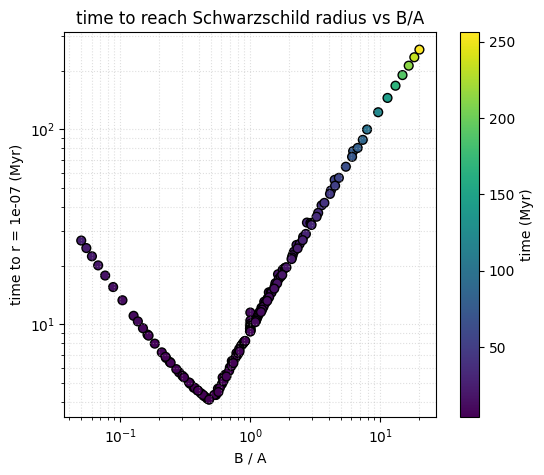

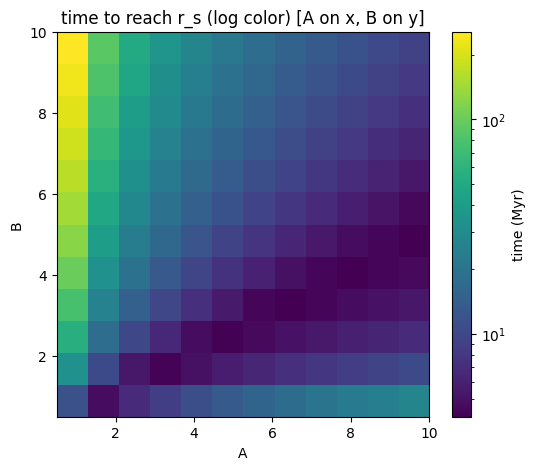

In [10]:
times_Myr = times_mat
plt.figure(figsize=(6,5))
ratios = (B_vals[None,:] / A_vals[:,None]).ravel()
times_flat = times_Myr.ravel()
mask = np.isfinite(times_flat)
plt.scatter(ratios[mask], times_flat[mask], c=times_flat[mask], cmap='viridis', s=40, edgecolor='k')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('B / A')
plt.ylabel(f'time to r = {rp_target} (Myr)')
plt.title('time to reach Schwarzschild radius vs B/A')
cbar = plt.colorbar()
cbar.set_label('time (Myr)')
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(times_Myr.T, origin='lower', aspect='auto',
           extent=[A_vals.min(), A_vals.max(), B_vals.min(), B_vals.max()],
           norm=plt.matplotlib.colors.LogNorm(vmin=np.nanmin(times_Myr[np.isfinite(times_Myr)]),
                                              vmax=np.nanmax(times_Myr[np.isfinite(times_Myr)])))
plt.colorbar(label='time (Myr)')
plt.xlabel('A')
plt.ylabel('B')
plt.title('time to reach r_s (log color) [A on x, B on y]')
plt.show()


In [14]:
import numpy as np
import math
from numba import njit, prange


r0 = 1.0
rp_target = 1e-7
x0, y0 = r0, 0.0
def circular_speed(r): return math.sqrt(1.0/(4.0*r))
vc0 = circular_speed(r0)
v_init_factor = 0.4


@njit(inline='always')
def rhs_into_numba(s, A, B, out):
    x = s[0]; y = s[1]; vx = s[2]; vy = s[3]
    r2 = x*x + y*y
    if r2 > 0.0:
        r = math.sqrt(r2)
        pref = -1.0 / (4.0 * r2 * r)
        ax = pref * x
        ay = pref * y
    else:
        ax = 0.0; ay = 0.0
    v2 = vx*vx + vy*vy
    if v2 > 0.0:
        v = math.sqrt(v2)
        dfpref = -A / (v*v*v + B)
        dfx = dfpref * vx
        dfy = dfpref * vy
    else:
        dfx = 0.0; dfy = 0.0
    out[0] = vx
    out[1] = vy
    out[2] = ax + dfx
    out[3] = ay + dfy


@njit(inline='always')
def rk4_increment_into(s, h, A, B, dst, tmp1, tmp2, tmp3, k1, k2, k3, k4):
    # k arrays and tmp arrays are preallocated float64[4]
    rhs_into_numba(s, A, B, k1); 
    for i in range(4): k1[i] *= h
    for i in range(4): tmp1[i] = s[i] + 0.5 * k1[i]

    rhs_into_numba(tmp1, A, B, k2)
    for i in range(4): k2[i] *= h
    for i in range(4): tmp2[i] = s[i] + 0.5 * k2[i]

    rhs_into_numba(tmp2, A, B, k3)
    for i in range(4): k3[i] *= h
    for i in range(4): tmp3[i] = s[i] + k3[i]

    rhs_into_numba(tmp3, A, B, k4)
    for i in range(4): k4[i] *= h

    for i in range(4):
        dst[i] = (k1[i] + 2.0*k2[i] + 2.0*k3[i] + k4[i]) * (1.0/6.0)


@njit
def adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, max_retries,
                            k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2):
    retries = 0
    while retries < max_retries:
        if h < h_min: h = h_min
        if h > h_max: h = h_max

        # first half-step: RK4 of size h => d1
        rk4_increment_into(s, h, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # second half-step: RK4 of size h on s+d1 => d2
        s1 = np.empty(4, dtype=np.float64)
        for i in range(4): s1[i] = s[i] + d1[i]
        rk4_increment_into(s1, h, A, B, d2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        for i in range(4): dr1[i] = d1[i] + d2[i]  # advance by 2h

        # full step of size 2h => dr2
        rk4_increment_into(s, 2.0*h, A, B, dr2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # position-only error
        diffx = dr1[0] - dr2[0]
        diffy = dr1[1] - dr2[1]
        error = math.hypot(diffx, diffy) / 30.0

        if not math.isfinite(error) or error <= 0.0:
            if error == 0.0:
                rho = 1e12
            else:
                rho = 0.0
        else:
            rho = h * delta_local / error

        if rho > 0.0:
            factor = rho**0.25
        else:
            factor = 0.5

        if rho >= 1.0:
            # Richardson correction on positions
            dr1[0] += diffx / 15.0
            dr1[1] += diffy / 15.0
            s_new = np.empty(4, dtype=np.float64)
            for i in range(4): s_new[i] = s[i] + dr1[i]
            t_inc = 2.0 * h
            h_new = 2.0*h if factor > 2.0 else factor*h
            if h_new < h_min: h_new = h_min
            if h_new > h_max: h_new = h_max
            return s_new, t_inc, h_new, True

        # shrink and retry
        h_new = factor * h
        if h_new >= h:
            h_new = 0.5 * h
        if h_new < h_min:
            return np.empty(4, dtype=np.float64), 0.0, h_min, False
        h = h_new
        retries += 1

    return np.empty(4, dtype=np.float64), 0.0, h_min, False


@njit
def integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    k1 = np.empty(4, dtype=np.float64)
    k2 = np.empty(4, dtype=np.float64)
    k3 = np.empty(4, dtype=np.float64)
    k4 = np.empty(4, dtype=np.float64)
    tmp1 = np.empty(4, dtype=np.float64)
    tmp2 = np.empty(4, dtype=np.float64)
    tmp3 = np.empty(4, dtype=np.float64)
    d1 = np.empty(4, dtype=np.float64)
    d2 = np.empty(4, dtype=np.float64)
    dr1 = np.empty(4, dtype=np.float64)
    dr2 = np.empty(4, dtype=np.float64)

    s = np.empty(4, dtype=np.float64)
    for i in range(4): s[i] = s0[i]

    t = 0.0
    h = h_init
    steps = 0

    while t < Tmax and steps < max_steps:
        if t + 2.0*h > Tmax:
            h_final = Tmax - t
            if h_final <= 0.0:
                break
            rk4_increment_into(s, h_final, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)
            for i in range(4): s[i] = s[i] + d1[i]
            t = Tmax
            break

        s_new, t_inc, h_new, ok = adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, 60,
                                                          k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2)
        if not ok:
            break
        for i in range(4): s[i] = s_new[i]
        t += t_inc
        h = h_new
        steps += 1

        rnow = math.hypot(s[0], s[1])
        if rnow <= stop_r:
            return t  

    return np.nan


@njit(parallel=True)
def scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    na = A_vals.shape[0]
    nb = B_vals.shape[0]
    times_to_rs = np.empty((na, nb), dtype=np.float64)
    for i in prange(na):
        A = A_vals[i]
        for j in range(nb):
            B = B_vals[j]
            t_hit = integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
            times_to_rs[i, j] = t_hit
    return times_to_rs

def run_scan_numba(A_vals, B_vals, s0, Tmax=1e6, h_init=1e-2, delta_local=1e-5,
                   h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000):
    # warmup compile
    print("Compiling/priming numba functions (first call)...")
    times_dummy = scan_grid_numba(np.array([0.5]), np.array([0.5]), s0, 1.0, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    # actual run
    times_mat = scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    success = ~np.isnan(times_mat)
    return times_mat, success


A_vals = np.linspace(0.5, 10.0, 12)
B_vals = np.linspace(0.5, 10.0, 12)
v0 = v_init_factor * vc0
s0 = np.array([x0, y0, 0.0, v0], dtype=np.float64)
times_mat, success = run_scan_numba(A_vals, B_vals, s0,
                                    Tmax=1e6, h_init=1e-2, delta_local=1e-8,
                                    h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000000)
print("Scan finished. successful grid points:", np.sum(success))


Compiling/priming numba functions (first call)...
Scan finished. successful grid points: 144


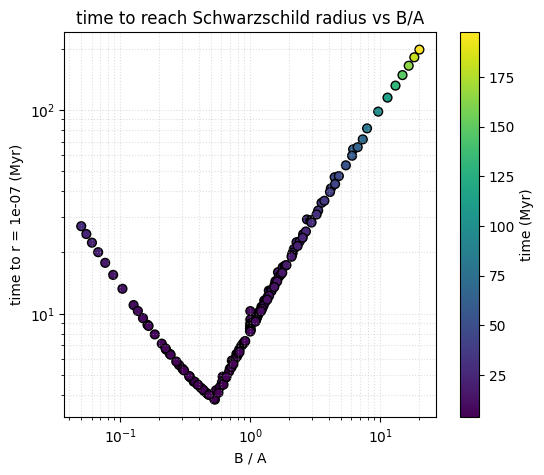

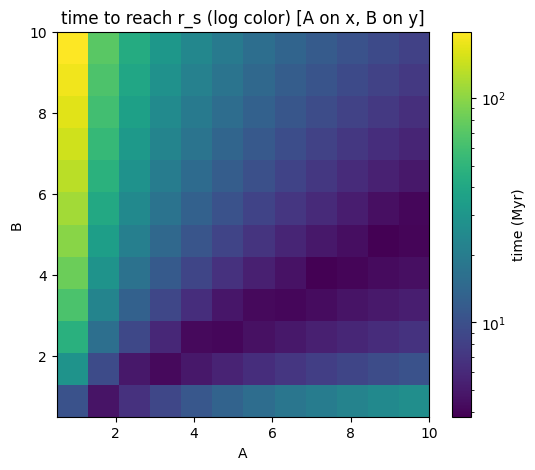

In [15]:
times_Myr = times_mat
plt.figure(figsize=(6,5))
ratios = (B_vals[None,:] / A_vals[:,None]).ravel()
times_flat = times_Myr.ravel()
mask = np.isfinite(times_flat)
plt.scatter(ratios[mask], times_flat[mask], c=times_flat[mask], cmap='viridis', s=40, edgecolor='k')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('B / A')
plt.ylabel(f'time to r = {rp_target} (Myr)')
plt.title('time to reach Schwarzschild radius vs B/A')
cbar = plt.colorbar()
cbar.set_label('time (Myr)')
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(times_Myr.T, origin='lower', aspect='auto',
           extent=[A_vals.min(), A_vals.max(), B_vals.min(), B_vals.max()],
           norm=plt.matplotlib.colors.LogNorm(vmin=np.nanmin(times_Myr[np.isfinite(times_Myr)]),
                                              vmax=np.nanmax(times_Myr[np.isfinite(times_Myr)])))
plt.colorbar(label='time (Myr)')
plt.xlabel('A')
plt.ylabel('B')
plt.title('time to reach r_s (log color) [A on x, B on y]')
plt.show()


In [16]:
import numpy as np
import math
from numba import njit, prange


r0 = 1.0
rp_target = 1e-7
x0, y0 = r0, 0.0
def circular_speed(r): return math.sqrt(1.0/(4.0*r))
vc0 = circular_speed(r0)
v_init_factor = 1.5


@njit(inline='always')
def rhs_into_numba(s, A, B, out):
    x = s[0]; y = s[1]; vx = s[2]; vy = s[3]
    r2 = x*x + y*y
    if r2 > 0.0:
        r = math.sqrt(r2)
        pref = -1.0 / (4.0 * r2 * r)
        ax = pref * x
        ay = pref * y
    else:
        ax = 0.0; ay = 0.0
    v2 = vx*vx + vy*vy
    if v2 > 0.0:
        v = math.sqrt(v2)
        dfpref = -A / (v*v*v + B)
        dfx = dfpref * vx
        dfy = dfpref * vy
    else:
        dfx = 0.0; dfy = 0.0
    out[0] = vx
    out[1] = vy
    out[2] = ax + dfx
    out[3] = ay + dfy


@njit(inline='always')
def rk4_increment_into(s, h, A, B, dst, tmp1, tmp2, tmp3, k1, k2, k3, k4):
    # k arrays and tmp arrays are preallocated float64[4]
    rhs_into_numba(s, A, B, k1); 
    for i in range(4): k1[i] *= h
    for i in range(4): tmp1[i] = s[i] + 0.5 * k1[i]

    rhs_into_numba(tmp1, A, B, k2)
    for i in range(4): k2[i] *= h
    for i in range(4): tmp2[i] = s[i] + 0.5 * k2[i]

    rhs_into_numba(tmp2, A, B, k3)
    for i in range(4): k3[i] *= h
    for i in range(4): tmp3[i] = s[i] + k3[i]

    rhs_into_numba(tmp3, A, B, k4)
    for i in range(4): k4[i] *= h

    for i in range(4):
        dst[i] = (k1[i] + 2.0*k2[i] + 2.0*k3[i] + k4[i]) * (1.0/6.0)


@njit
def adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, max_retries,
                            k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2):
    retries = 0
    while retries < max_retries:
        if h < h_min: h = h_min
        if h > h_max: h = h_max

        # first half-step: RK4 of size h => d1
        rk4_increment_into(s, h, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # second half-step: RK4 of size h on s+d1 => d2
        s1 = np.empty(4, dtype=np.float64)
        for i in range(4): s1[i] = s[i] + d1[i]
        rk4_increment_into(s1, h, A, B, d2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        for i in range(4): dr1[i] = d1[i] + d2[i]  # advance by 2h

        # full step of size 2h => dr2
        rk4_increment_into(s, 2.0*h, A, B, dr2, tmp1, tmp2, tmp3, k1, k2, k3, k4)

        # position-only error
        diffx = dr1[0] - dr2[0]
        diffy = dr1[1] - dr2[1]
        error = math.hypot(diffx, diffy) / 30.0

        if not math.isfinite(error) or error <= 0.0:
            if error == 0.0:
                rho = 1e12
            else:
                rho = 0.0
        else:
            rho = h * delta_local / error

        if rho > 0.0:
            factor = rho**0.25
        else:
            factor = 0.5

        if rho >= 1.0:
            # Richardson correction on positions
            dr1[0] += diffx / 15.0
            dr1[1] += diffy / 15.0
            s_new = np.empty(4, dtype=np.float64)
            for i in range(4): s_new[i] = s[i] + dr1[i]
            t_inc = 2.0 * h
            h_new = 2.0*h if factor > 2.0 else factor*h
            if h_new < h_min: h_new = h_min
            if h_new > h_max: h_new = h_max
            return s_new, t_inc, h_new, True

        # shrink and retry
        h_new = factor * h
        if h_new >= h:
            h_new = 0.5 * h
        if h_new < h_min:
            return np.empty(4, dtype=np.float64), 0.0, h_min, False
        h = h_new
        retries += 1

    return np.empty(4, dtype=np.float64), 0.0, h_min, False


@njit
def integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    k1 = np.empty(4, dtype=np.float64)
    k2 = np.empty(4, dtype=np.float64)
    k3 = np.empty(4, dtype=np.float64)
    k4 = np.empty(4, dtype=np.float64)
    tmp1 = np.empty(4, dtype=np.float64)
    tmp2 = np.empty(4, dtype=np.float64)
    tmp3 = np.empty(4, dtype=np.float64)
    d1 = np.empty(4, dtype=np.float64)
    d2 = np.empty(4, dtype=np.float64)
    dr1 = np.empty(4, dtype=np.float64)
    dr2 = np.empty(4, dtype=np.float64)

    s = np.empty(4, dtype=np.float64)
    for i in range(4): s[i] = s0[i]

    t = 0.0
    h = h_init
    steps = 0

    while t < Tmax and steps < max_steps:
        if t + 2.0*h > Tmax:
            h_final = Tmax - t
            if h_final <= 0.0:
                break
            rk4_increment_into(s, h_final, A, B, d1, tmp1, tmp2, tmp3, k1, k2, k3, k4)
            for i in range(4): s[i] = s[i] + d1[i]
            t = Tmax
            break

        s_new, t_inc, h_new, ok = adaptive_rk4_step_numba(s, h, delta_local, h_min, h_max, A, B, 60,
                                                          k1, k2, k3, k4, tmp1, tmp2, tmp3, d1, d2, dr1, dr2)
        if not ok:
            break
        for i in range(4): s[i] = s_new[i]
        t += t_inc
        h = h_new
        steps += 1

        rnow = math.hypot(s[0], s[1])
        if rnow <= stop_r:
            return t  

    return np.nan


@njit(parallel=True)
def scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps):
    na = A_vals.shape[0]
    nb = B_vals.shape[0]
    times_to_rs = np.empty((na, nb), dtype=np.float64)
    for i in prange(na):
        A = A_vals[i]
        for j in range(nb):
            B = B_vals[j]
            t_hit = integrate_single_numba(A, B, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
            times_to_rs[i, j] = t_hit
    return times_to_rs

def run_scan_numba(A_vals, B_vals, s0, Tmax=1e6, h_init=1e-2, delta_local=1e-5,
                   h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000):
    # warmup compile
    print("Compiling/priming numba functions (first call)...")
    times_dummy = scan_grid_numba(np.array([0.5]), np.array([0.5]), s0, 1.0, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    # actual run
    times_mat = scan_grid_numba(A_vals, B_vals, s0, Tmax, h_init, delta_local, h_min, h_max, stop_r, max_steps)
    success = ~np.isnan(times_mat)
    return times_mat, success


A_vals = np.linspace(0.5, 10.0, 12)
B_vals = np.linspace(0.5, 10.0, 12)
v0 = v_init_factor * vc0
s0 = np.array([x0, y0, 0.0, v0], dtype=np.float64)
times_mat, success = run_scan_numba(A_vals, B_vals, s0,
                                    Tmax=1e6, h_init=1e-2, delta_local=1e-8,
                                    h_min=1e-14, h_max=1.0, stop_r=rp_target, max_steps=200000000)
print("Scan finished. successful grid points:", np.sum(success))


Compiling/priming numba functions (first call)...
Scan finished. successful grid points: 144


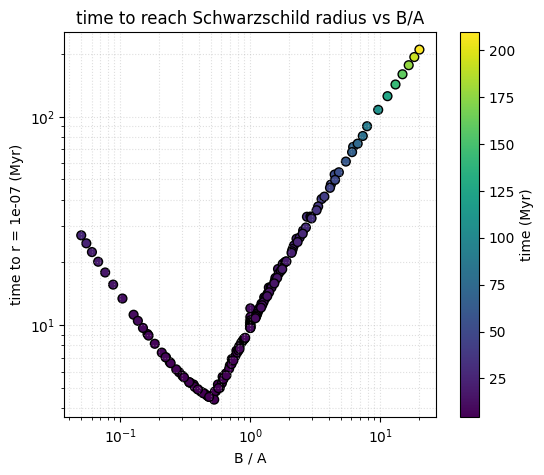

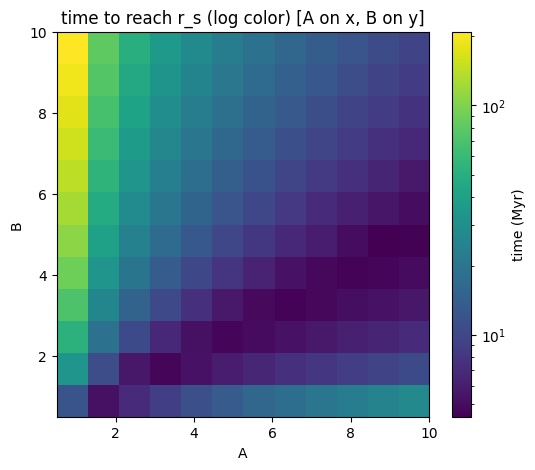

In [17]:
times_Myr = times_mat
plt.figure(figsize=(6,5))
ratios = (B_vals[None,:] / A_vals[:,None]).ravel()
times_flat = times_Myr.ravel()
mask = np.isfinite(times_flat)
plt.scatter(ratios[mask], times_flat[mask], c=times_flat[mask], cmap='viridis', s=40, edgecolor='k')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('B / A')
plt.ylabel(f'time to r = {rp_target} (Myr)')
plt.title('time to reach Schwarzschild radius vs B/A')
cbar = plt.colorbar()
cbar.set_label('time (Myr)')
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(times_Myr.T, origin='lower', aspect='auto',
           extent=[A_vals.min(), A_vals.max(), B_vals.min(), B_vals.max()],
           norm=plt.matplotlib.colors.LogNorm(vmin=np.nanmin(times_Myr[np.isfinite(times_Myr)]),
                                              vmax=np.nanmax(times_Myr[np.isfinite(times_Myr)])))
plt.colorbar(label='time (Myr)')
plt.xlabel('A')
plt.ylabel('B')
plt.title('time to reach r_s (log color) [A on x, B on y]')
plt.show()
